In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from algorithms.mean_based import mean_based
from algorithms.volatility_based import volatility_based
from algorithms.correlation_based import correlation_based
from visualizations.scatter_plot import scatter_plot
from visualizations.autocorrelation_plot import autocorrelation_plot
from visualizations.create_filtered_table import create_filtered_table

In [2]:
# import pandas as pd
# import numpy as np
# import matplotlib.pyplot as plt
# import seaborn as sns
# # from algorithm import correlation_based

# # --- Read and process sample data ---
# # Assume the file 'thingspeak_dataset.csv' has the following structure:
# # created_at,entry_id,field1,field2,field3,field4,field5,field6,field7,field8
# df = pd.read_csv('datasets/2881821.csv', parse_dates=['created_at'])
# df.sort_values(by='created_at', inplace=True)
# df.set_index('created_at', inplace=True)
# df = df.interpolate()

# # --- Example usage of the detect_outlier_streams function ---
# # Choose at least 3 streams for analysis, for example: field1, field2, field3, field5
streams_to_check = ['field1', 'field2', 'field3','field6']
start_date = '2025-03-18 06:54:00'
end_date = '2025-03-19 07:02:42'

# results = volatility_based(df, streams_to_check, start_date, end_date)

# print("\nOutlier detection results:")
# print(results)


In [3]:
df = pd.read_csv('datasets/2881821.csv', parse_dates=['created_at'])
print(df.columns)
df['created_at'] = pd.to_datetime(df['created_at'])

Index(['created_at', 'entry_id', 'field1', 'field2', 'field3', 'field4',
       'field5', 'field6', 'field7', 'field8'],
      dtype='object')


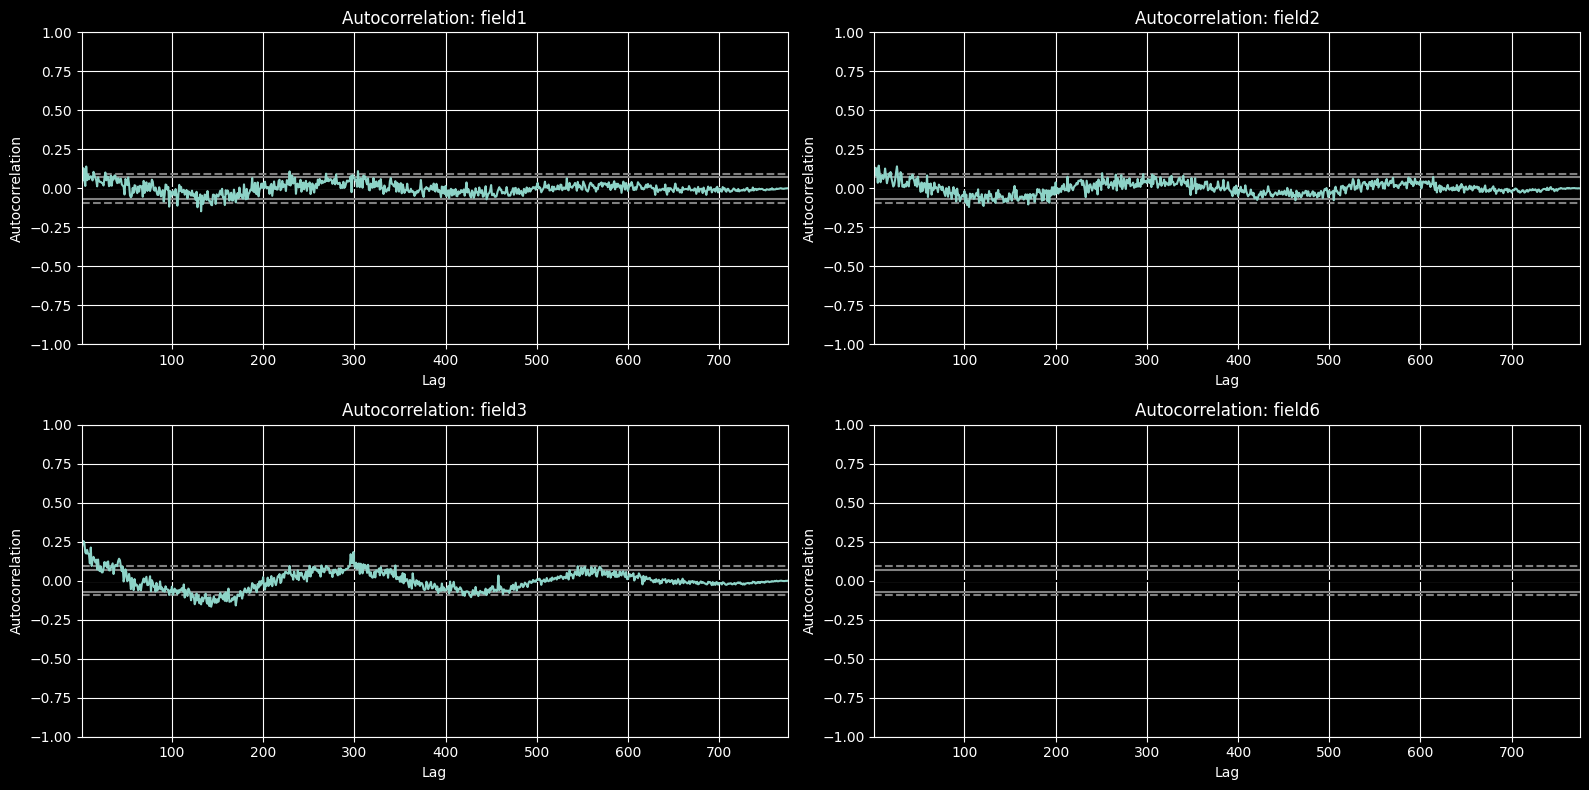

In [4]:
autocorrelation_plot(df, streams_to_check, start_date, end_date, style='dark')

In [5]:
plt.style.available


['Solarize_Light2',
 '_classic_test_patch',
 '_mpl-gallery',
 '_mpl-gallery-nogrid',
 'bmh',
 'classic',
 'dark_background',
 'fast',
 'fivethirtyeight',
 'ggplot',
 'grayscale',
 'petroff10',
 'seaborn-v0_8',
 'seaborn-v0_8-bright',
 'seaborn-v0_8-colorblind',
 'seaborn-v0_8-dark',
 'seaborn-v0_8-dark-palette',
 'seaborn-v0_8-darkgrid',
 'seaborn-v0_8-deep',
 'seaborn-v0_8-muted',
 'seaborn-v0_8-notebook',
 'seaborn-v0_8-paper',
 'seaborn-v0_8-pastel',
 'seaborn-v0_8-poster',
 'seaborn-v0_8-talk',
 'seaborn-v0_8-ticks',
 'seaborn-v0_8-white',
 'seaborn-v0_8-whitegrid',
 'tableau-colorblind10']

In [6]:
create_filtered_table(df, streams_to_check, start_date, end_date)

Loading BokehJS ...